In [53]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from itertools import product

import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17,6)});
sns.set(style='whitegrid')

# Импорт библиотек

In [5]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

sns.set(rc={'figure.figsize':(17,5)})
sns.set(style='whitegrid');

# Загрузка данных

In [6]:
df = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])

print(df.shape)
df.head(3)

(2625, 1)


,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517


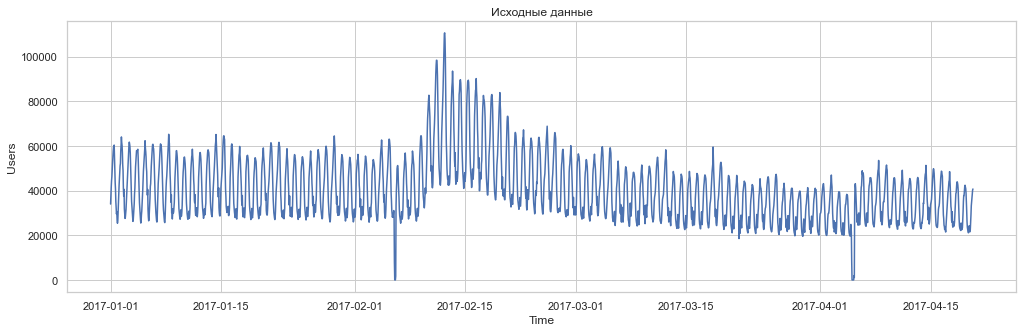

In [7]:
sns.lineplot(x=df.index, y='Users', data=df);
#plt.xticks(rotation=45)
plt.title('Исходные данные');

# Скользящая средняя

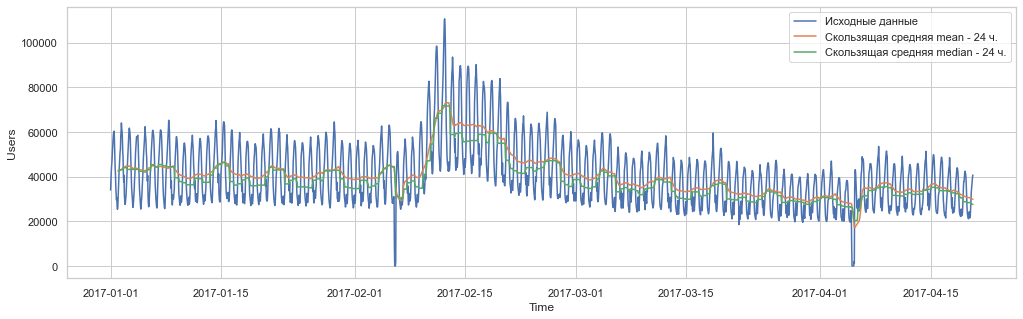

In [8]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).mean(), label='Скользящая средняя mean - 24 ч.');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).median(), label='Скользящая средняя median - 24 ч.');

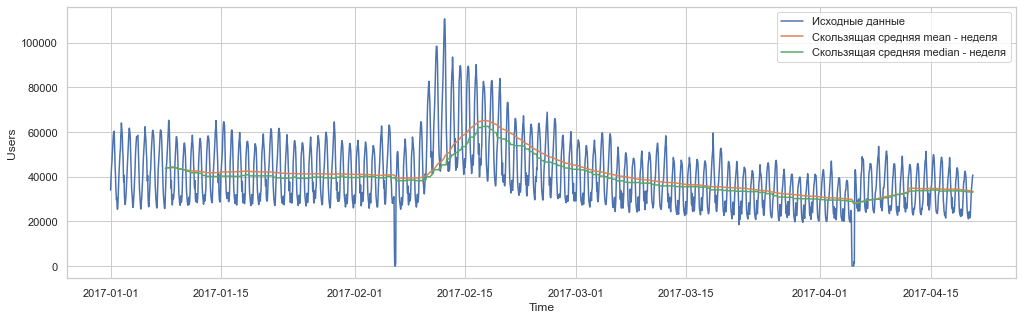

In [9]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).mean(), label='Скользящая средняя mean - неделя');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).median(), label='Скользящая средняя median - неделя');

# Взвешенная средняя

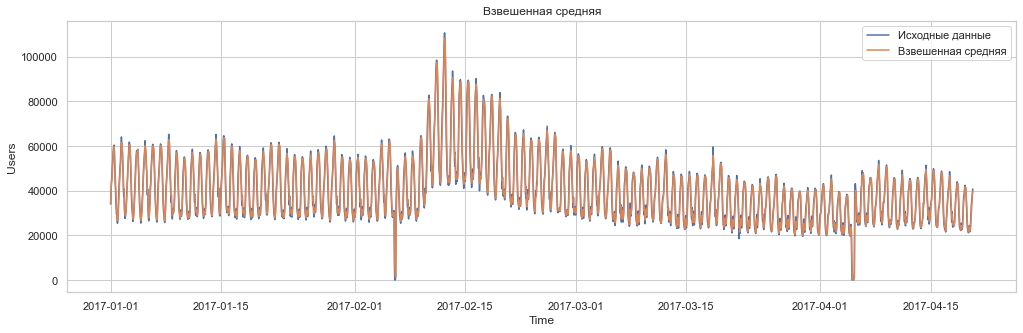

In [10]:
def weighted_average(series, weights):
    w = len(weights)
    result = list(series[0:w-1]) # Первые значения оставляем как есть

    for n in range(0, len(series)-w+1):
        b = series[n:n+w]
        result.append(sum(b * weights))
    return result

sns.lineplot(x=df.index, y=df.Users, label='Исходные данные')
sns.lineplot(x=df.index, y=weighted_average(df.Users, [0.03,0.07,0.1,0.2,0.6]), label='Взвешенная средняя')

plt.title('Взвешенная средняя');

# Экспоненциальное сглаживание

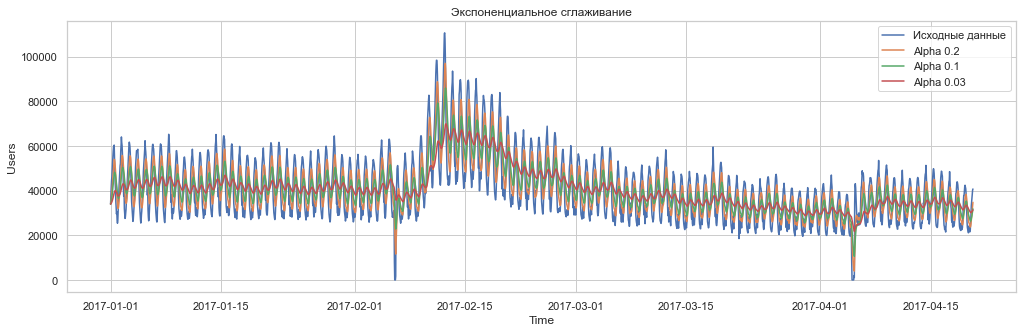

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # Первое значение оставляем как есть
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

sns.lineplot(x=df.index, y=df.Users, label='Исходные данные')

for alpha in [0.2, 0.1, 0.03]:
    sns.lineplot(x=df.index, y=exponential_smoothing(df.Users, alpha), label=f'Alpha {alpha}')

plt.title('Экспоненциальное сглаживание');

# Двойное экспоненциальное сглаживание

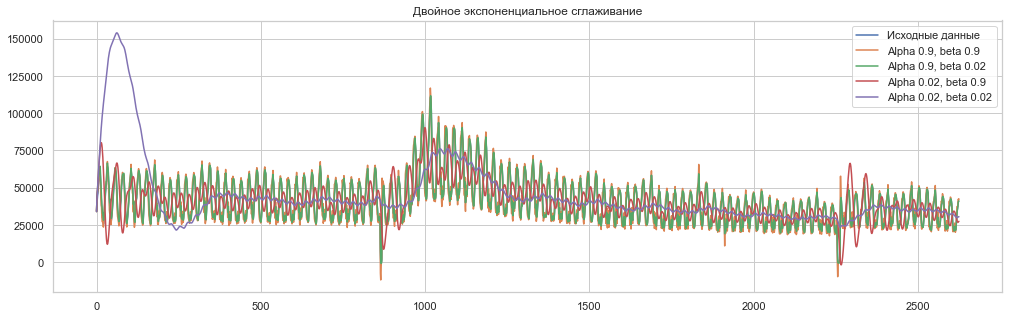

In [12]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level = series[0]
            trend = series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        
        last_level = level
        level = alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        
    return result

plt.plot(df.Users.values, label = 'Исходные данные')

for alpha in [0.9, 0.02]:
    for beta in [0.9, 0.02]:
        plt.plot(double_exponential_smoothing(df.Users, alpha, beta), 
                 label=f'Alpha {alpha}, beta {beta}')
        
plt.title('Двойное экспоненциальное сглаживание');
plt.legend(loc='best');

# SARIMA

Исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня (о нестационарности ряда).

Критерий Дики-Фуллера: p=0.19019


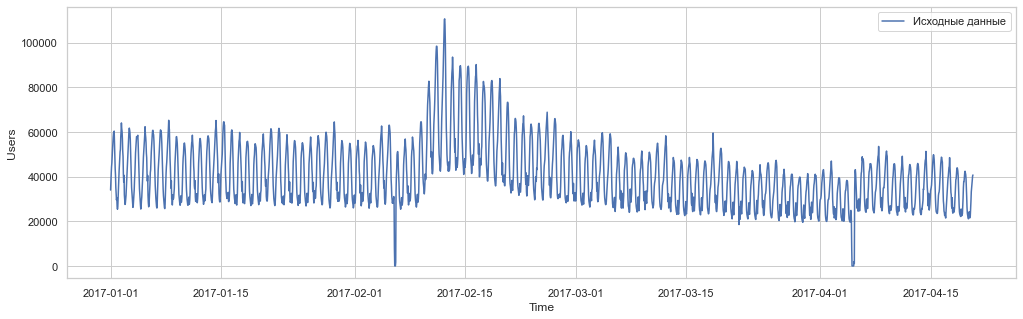

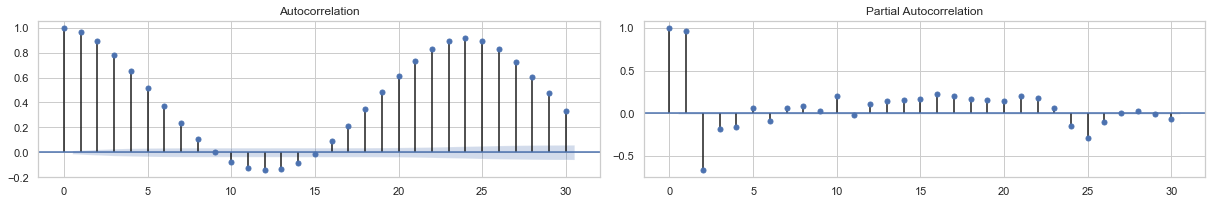

In [13]:
dfuller = round(sm.tsa.stattools.adfuller(df['Users'])[1],5)
print(f"Критерий Дики-Фуллера: p={dfuller}")

sns.lineplot(x=df.index, y=df['Users'], label='Исходные данные');

fig = plt.figure(figsize=(17,3))
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(df['Users'], lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(df['Users'], lags=30, ax=pacf_ax, alpha=0.5)
plt.tight_layout()

Стабилизируем дисперсию преоразованием Бокса-Кокса.
Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда.

Критерий Дики-Фуллера: p=0.07976
Оптимальный параметр преобразования Бокса-Кокса: 0.58727


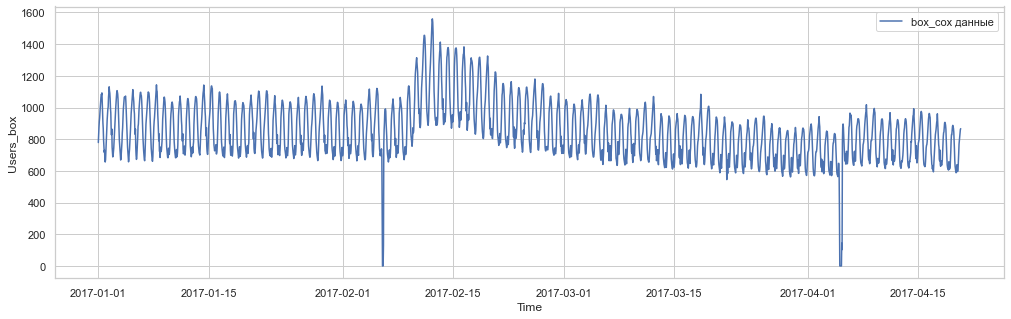

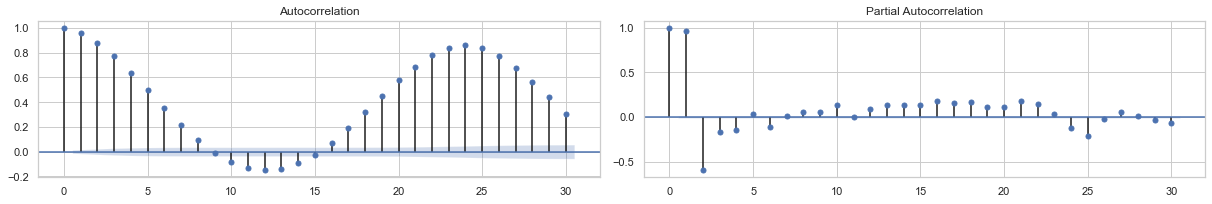

In [14]:
df['Users_box'], lmbda = scs.boxcox(df['Users']+1) # прибавляем единицу, так как в исходном ряде есть нули

dfuller = round(sm.tsa.stattools.adfuller(df['Users_box'])[1],5)

print(f"Критерий Дики-Фуллера: p={dfuller}")
print(f"Оптимальный параметр преобразования Бокса-Кокса: {round(lmbda,5)}")
 
sns.lineplot(x=df.index, y=df['Users_box'], label='box_cox данные');

fig = plt.figure(figsize=(17,3))
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))

smt.graphics.plot_acf(df['Users_box'], lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(df['Users_box'], lags=30, ax=pacf_ax, alpha=0.5)
plt.tight_layout()

А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.00257


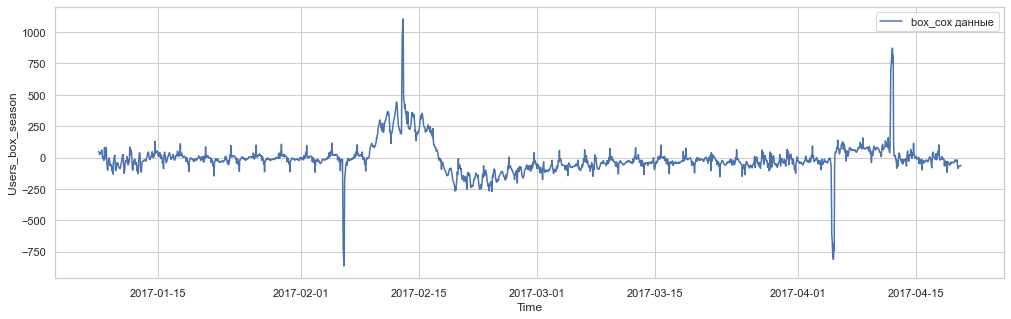

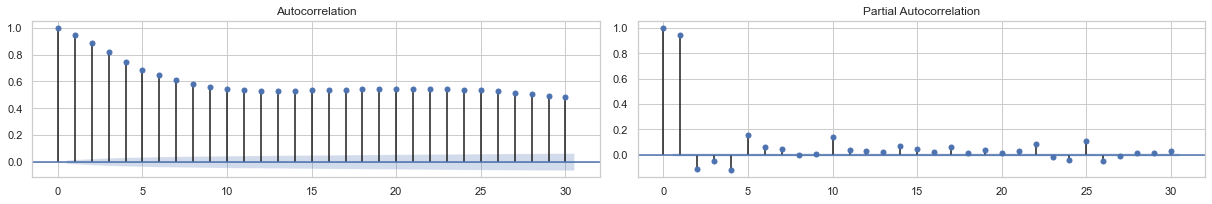

In [15]:
df['Users_box_season'] = df['Users_box'] - df['Users_box'].shift(24*7)

dfuller = round(sm.tsa.stattools.adfuller(df['Users_box_season'][24*7:])[1], 5)
print(f"Критерий Дики-Фуллера: p={dfuller}")

sns.lineplot(x=df[24*7:].index, y=df['Users_box_season'][24*7:], label='box_cox данные');

fig = plt.figure(figsize=(17,3))
acf_ax = plt.subplot2grid((1, 2), (0, 0))
pacf_ax = plt.subplot2grid((1, 2), (0, 1))

smt.graphics.plot_acf(df['Users_box_season'][24*7:], lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(df['Users_box_season'][24*7:], lags=30, ax=pacf_ax, alpha=0.5)
plt.tight_layout()

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести наконец ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.0


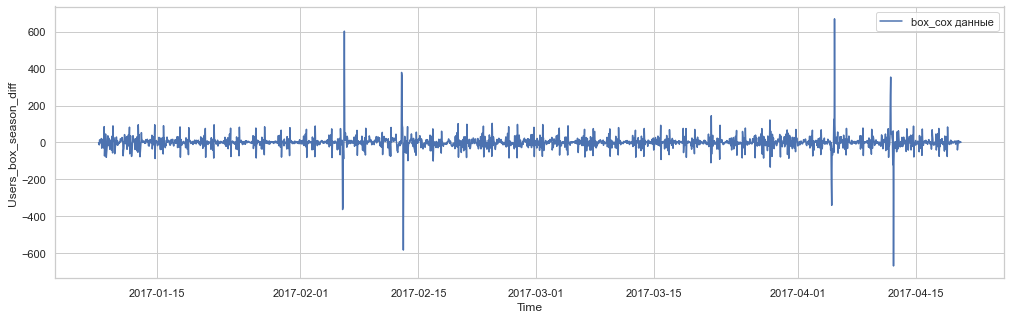

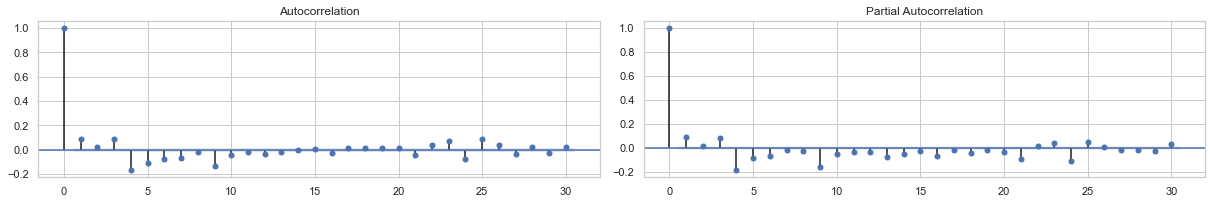

In [16]:
df['Users_box_season_diff'] = df['Users_box_season'] - df['Users_box_season'].shift(1)

dfuller = round(sm.tsa.stattools.adfuller(df['Users_box_season_diff'][24*7+1:])[1], 5)
print(f"Критерий Дики-Фуллера: p={dfuller}")

sns.lineplot(x=df[24*7+1:].index, y=df['Users_box_season_diff'][24*7+1:], label='box_cox данные');

fig = plt.figure(figsize=(17,3))
acf_ax = plt.subplot2grid((1, 2), (0, 0))
pacf_ax = plt.subplot2grid((1, 2), (0, 1))

smt.graphics.plot_acf(df['Users_box_season_diff'][24*7+1:], lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(df['Users_box_season_diff'][24*7+1:], lags=30, ax=pacf_ax, alpha=0.5)
plt.tight_layout()

In [19]:
best_model = sm.tsa.statespace.SARIMAX(
    df['Users_box'],
    order=(4, 1, 3),
    seasonal_order=(4, 1, 1, 24)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            Users_box   No. Observations:                 2625
Model:             SARIMAX(4, 1, 3)x(4, 1, [1], 24)   Log Likelihood              -12551.769
Date:                              Mon, 14 Sep 2020   AIC                          25129.538
Time:                                      00:24:29   BIC                          25205.761
Sample:                                           0   HQIC                         25157.156
                                             - 2625                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2308      0.309      3.986      0.000       0.626       1.836
ar.L2         -0.59

Критерий Дики-Фуллера: p=0.0


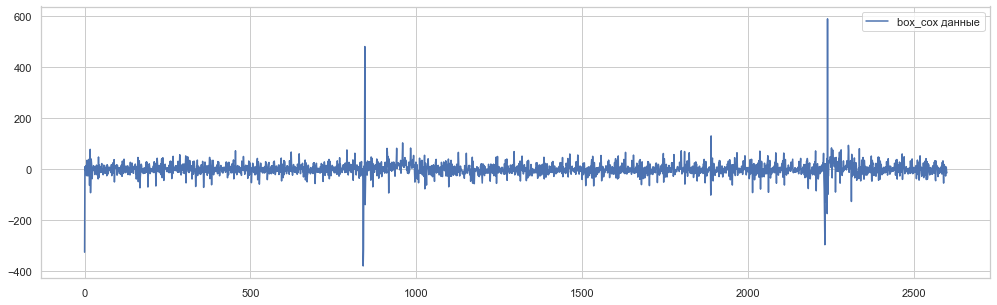

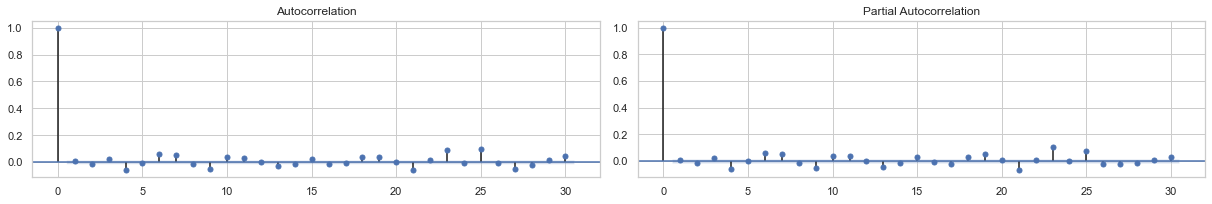

In [23]:
dfuller = round(sm.tsa.stattools.adfuller(best_model.resid[24:])[1], 5)
print(f"Критерий Дики-Фуллера: p={dfuller}")

sns.lineplot(x=range(0,len(best_model.resid[24:])), y=best_model.resid[24:], label='box_cox данные');

fig = plt.figure(figsize=(17,3))
acf_ax = plt.subplot2grid((1, 2), (0, 0))
pacf_ax = plt.subplot2grid((1, 2), (0, 1))

smt.graphics.plot_acf(best_model.resid[24:], lags=30, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(best_model.resid[24:], lags=30, ax=pacf_ax, alpha=0.5)
plt.tight_layout()